### This notebook is supposed to be used as template/check for your work. 
### Depending on the star cluster you are observing as well as the particulars of your data analysis, there will be changes to the final results. I also do not claim to have done a rigorous job here. 
### Nevertheless, this should serve as a rough guideline.


#### First we will load the necessary python modules. Let your demonstrator know if there are any errors here.
In case you're doing this on your personal machine, all of these can be installed using conda.

In [1]:
# Bare minimum nuts-and-bolts of python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib 

In [2]:
#astro-specific packages
from astropy.nddata import CCDData
from astropy.io import fits
from astropy import units as u
import ccdproc as ccdp
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus

Next we will read in the FITS files. In this notebook we are only going to read in the B-band and (later) V-band files

In [3]:
dir_name = "./data/T17/NGC_2520/"

In [4]:
# M93_B = CCDData.read(dir_name+"M93_B.fits", unit='adu')
# M93_B_flat = CCDData.read(dir_name+"flat_B.fits", unit='adu')
# M93_bias = CCDData.read(dir_name+"bias.fits", unit='adu')

In [5]:
NGC_2520_B = CCDData.read(
    dir_name+"calibrated-T17-phy3_s1g4_2021-NGC_2520-20230120-003203-B-BIN1-E-120-001.fit",
    unit="adu")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### It is always a good practice to take a look at your data to understand ''how it looks like'' (i.e. metadata, float vs int, etc and also to make sure nothing is broken!)

In [6]:
NGC_2520_B.data #Check that the data has read in correctly.

array([[102.27632 , 244.54689 , 184.72852 , ..., 177.21088 , 258.70374 ,
        102.23129 ],
       [164.34372 , 135.6292  , 227.60336 , ..., 197.91853 , 129.85822 ,
        114.948456],
       [138.10071 , 147.33719 , 131.81673 , ..., 109.63575 , 149.67354 ,
        148.72102 ],
       ...,
       [153.7651  , 149.46936 , 142.86142 , ..., 131.03488 ,  78.03567 ,
        118.37893 ],
       [170.83148 , 149.65616 , 222.4772  , ..., 132.3615  ,  97.75071 ,
        204.57207 ],
       [180.22787 , 182.41699 , 140.32162 , ..., 117.541595, 151.41928 ,
        135.85254 ]], dtype=float32)

Remove the bias frame from the science image:

Remove the flat field from the bias-subtracted image:

----

## Next we'll load in the star list made with DS9.

### When you open your fits file in DS9, it will look something like this:

<img src="./figs/1.png">

#### After putting regions over the stars, they will roughly look like the following. You then export them to a ".txt" file which is what we are reading in next.

<img src="./figs/2.png">

In [7]:
star_coords = np.loadtxt(fname=dir_name+'../NGC_2520_starlist.txt', delimiter=' ')

In [8]:
print(star_coords.shape)

(100, 2)


#### I have therefore saved the locations for 100 stars. The more stars you marks, the better it is.

## Photometry

First, get the counts from each star in each filter:

In [9]:
apertures = CircularAperture(star_coords, r=4.0)
rawphot_B = aperture_photometry(NGC_2520_B, apertures) 

Subtract background light:

In [10]:
annuli = CircularAnnulus(star_coords, 6.0, 8.0)
sky_B = aperture_photometry(NGC_2520_B, annuli)

phot_B = rawphot_B["aperture_sum"] - sky_B["aperture_sum"]

In [11]:
NGC_2520_V = CCDData.read(
    dir_name+"calibrated-T17-phy3_s1g4_2021-NGC_2520-20230120-002944-V-BIN1-E-120-001.fit",
    unit="adu")

rawphot_V = aperture_photometry(NGC_2520_V, apertures) 

sky_V = aperture_photometry(NGC_2520_V, annuli)

phot_V = rawphot_V["aperture_sum"] - sky_V["aperture_sum"]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Calibrate counts into apparent magnitudes:

In [12]:
standard_star = {"count_B": phot_B[0],
            "mag_B" : 9.99,
             "count_V" : phot_V[0],
              "mag_V" : 9.79,
            "distance" : 630}

In [13]:
mags_apparent_B = standard_star["mag_B"] + 2.5 * np.log10(phot_B/standard_star["count_B"])
mags_absolute_B = mags_apparent_B + 5 - 5*np.log10(standard_star["distance"])

/opt/miniconda3/envs/astro_labs/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [14]:
mags_apparent_V = standard_star["mag_V"] + 2.5 * np.log10(phot_V/standard_star["count_V"])
mags_absolute_V = mags_apparent_V + 5 - 5*np.log10(standard_star["distance"])

In [15]:
col_BV = mags_absolute_B - mags_absolute_V

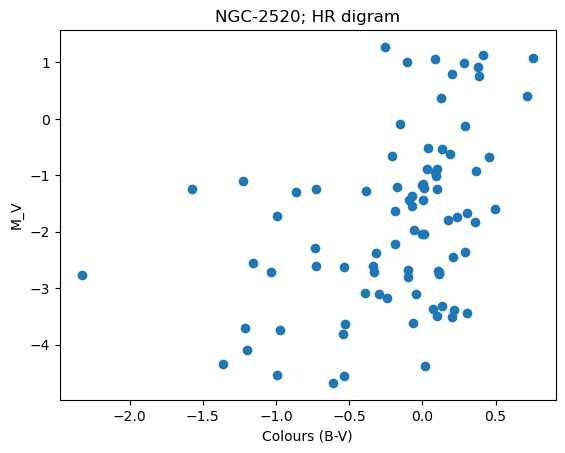

In [16]:
fig, ax = plt.subplots()
ax.scatter(col_BV, mags_absolute_V)

ax.set_xlabel("Colours (B-V)")
ax.set_ylabel("M_V")
ax.set_title("NGC-2520; HR digram")
plt.savefig("figs/NGC_2520_HR.pdf")

---
---